In [1]:
import os
import numpy
import pandas
import seaborn
import argparse
import mlflow
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')
seaborn.set_context('paper')

DATA_DIRECTORY = './petfinder_dataset/'
TARGET_COL = 'AdoptionSpeed'
 
SHUFFLE_BUFFER_SIZE = 100 

/users/jpanalian/miniconda3/envs/deeplearning/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


In [2]:
def load_dataset(dataset_dir):

    # Read train dataset (and maybe dev, if you need to...)
    dataset, dev_dataset = train_test_split(
        pandas.read_csv(os.path.join(dataset_dir, 'train.csv')), test_size=0.2)
         
    test_dataset = pandas.read_csv(os.path.join(dataset_dir, 'test.csv'))
    
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

In [3]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))
       
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    # Agregado por JPA -- Create and append numeric columns - Don't forget to normalize!
    for n_col in numeric_columns:
        features[n_col] =  df[n_col].values - df[n_col].mean() / df[n_col].std()
        
    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets

In [4]:
dataset, dev_dataset, test_dataset = load_dataset(DATA_DIRECTORY)
nlabels = dataset[TARGET_COL].unique().shape[0]

Training samples 8465, test_samples 4411


In [5]:
one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Type','Gender', 'Color1','Color2', 'Color3','MaturitySize','Vaccinated','Dewormed', 'Sterilized','Health', 'State']
}

embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2'] 
}

numeric_columns = ['Age', 'Fee']

In [6]:
BATCH_SIZE = 100

X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)

test_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(BATCH_SIZE)


In [7]:
X_kagg, y_kagg = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)

kagg_ds = tf.data.Dataset.from_tensor_slices(X_kagg).batch(BATCH_SIZE)

In [9]:
from pprint import pprint

for data in train_ds.take(1):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

({'Age': <tf.Tensor: id=62, shape=(100,), dtype=float64, numpy=
array([47.42715085,  1.42715085, 35.42715085,  0.42715085,  2.42715085,
       11.42715085,  3.42715085,  4.42715085,  3.42715085,  5.42715085,
       11.42715085,  1.42715085,  5.42715085, 35.42715085,  3.42715085,
        2.42715085,  1.42715085,  9.42715085,  2.42715085, 83.42715085,
        0.42715085,  6.42715085,  4.42715085,  1.42715085,  0.42715085,
        1.42715085,  3.42715085, 23.42715085,  2.42715085,  1.42715085,
        1.42715085,  1.42715085,  3.42715085, 13.42715085,  1.42715085,
        1.42715085,  1.42715085,  2.42715085, 47.42715085,  1.42715085,
        3.42715085,  0.42715085,  5.42715085,  3.42715085,  2.42715085,
        5.42715085,  2.42715085,  1.42715085,  1.42715085,  0.42715085,
        3.42715085, 17.42715085,  2.42715085,  0.42715085,  1.42715085,
        2.42715085, 11.42715085,  2.42715085,  2.42715085,  2.42715085,
        1.42715085,  0.42715085, 23.42715085,  3.42715085, 11.42715085,


In [40]:
tf.keras.backend.clear_session()

In [41]:
HIDDEN_LAYER_SIZE = 36
DIRECT_FEATURES_INPUT_SHAPE = (X_train['direct_features'].shape[1],)
DROPOUT_RATE = 0.25

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []

for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=DIRECT_FEATURES_INPUT_SHAPE, name='direct_features')
inputs.append(direct_features_input)
            
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(HIDDEN_LAYER_SIZE, activation='relu')(features)

drop1 = layers.Dropout(DROPOUT_RATE)(dense1)

dense2 = layers.Dense(HIDDEN_LAYER_SIZE / 2, activation='relu')(drop1)

drop2 = layers.Dropout(DROPOUT_RATE)(dense2)

dense3 = layers.Dense(HIDDEN_LAYER_SIZE / 4, activation='relu')(drop2)

output_layer = layers.Dense(nlabels, activation='softmax')(dense3)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2


In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 77)        23716       Breed2[0][0]                     
______________________________________________________________________________________________

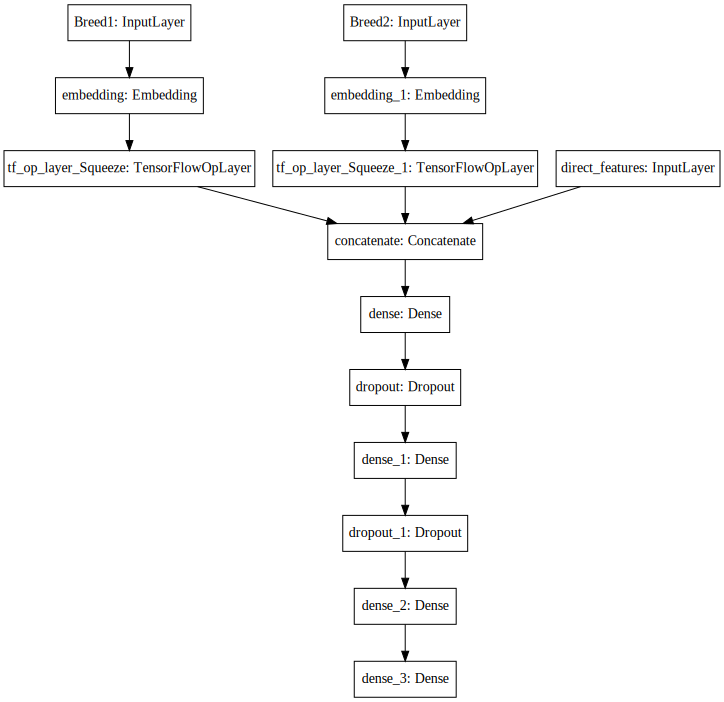

In [43]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [44]:
import mlflow
mlflow.set_experiment('tp1_corrida_04')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)  
    mlflow.log_param('train_dataset.shuffke', True)  
    mlflow.log_param('dropout', DROPOUT_RATE)
    # Train
    epochs = 12
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/12
85/85 [==============================] - 4s 47ms/step - loss: 1.5444 - accuracy: 0.2385
Epoch 2/12
85/85 [==============================] - 3s 36ms/step - loss: 1.4878 - accuracy: 0.2641
Epoch 3/12
85/85 [==============================] - 3s 39ms/step - loss: 1.4717 - accuracy: 0.2877
Epoch 4/12
85/85 [==============================] - 3s 36ms/step - loss: 1.4646 - accuracy: 0.2882
Epoch 5/12
85/85 [==============================] - 3s 38ms/step - loss: 1.4519 - accuracy: 0.3103
Epoch 6/12
85/85 [==============================] - 3s 39ms/step - loss: 1.4455 - accuracy: 0.3120
Epoch 7/12
85/85 [==============================] - 3s 37ms/step - loss: 1.4306 - accuracy: 0.3302
Epoch 8/12
85/85 [==============================] - 3s 38ms/step - loss: 1.4204 - accuracy: 0.3438
Epoch 9/12
85/85 [==============================] - 3s 37ms/step - loss: 1.4094 - accuracy: 0.3494
Epoch 10/12
85/85 [==============================] - 3s 37ms/step - loss: 1.3994 - accuracy: 0.3565
Epoch 11/

## Evaluando del modelo
Además de tener en cuenta las métricas de performance del modelo, es importante mirar los resultados obtenidos y controlar que el modelo efectivamente está aprendiendo algo relevante.

/users/jpanalian/miniconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:364: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(inputs, collections.Sequence):


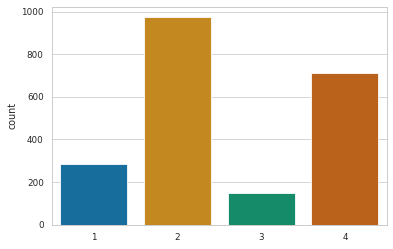

In [22]:
predictions = numpy.argmax(model.predict(test_ds), axis=1)
seaborn.countplot(predictions)

In [23]:
submission = pandas.DataFrame( list(zip( test_dataset['PID'], numpy.argmax(model.predict(kagg_ds), axis=1))), 
                              columns=["PID", "AdoptionSpeed"])

In [24]:
submission.to_csv(DATA_DIRECTORY + "submission_out_3.csv", header=True, index=False)

In [33]:
print(history.history)

{'loss': [1.5051638558991056, 1.4517754504332794, 1.4312456727943264, 1.4165737319823488, 1.4107639279790833, 1.4025469274825058, 1.3965387455612968, 1.3925882392709803, 1.3878408738021941, 1.3811526878726461, 1.3797700268519537, 1.3753422985961292, 1.3717566620859956, 1.3656208940462045, 1.365171435382052], 'accuracy': [0.28375664, 0.31234494, 0.33845246, 0.3509746, 0.34790313, 0.35534555, 0.358417, 0.36030716, 0.3679858, 0.36975783, 0.37188423, 0.3760189, 0.37341997, 0.3868872, 0.3862965]}


In [34]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_keras_api_names',
 '_keras_api_names_v1',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']